# Install and Import Dependencies

In [ ]:
!pip install torch torchvision pandas

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/drive/MyDrive/archive/CrashBest/" "/content/CrashBest"

# Read CSV and Prepare a Custom Dataset

In [32]:
class CrashDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        # Build a list of (img_path, label)
        self.samples = []
        for idx, row in self.df.iterrows():
            vidname = f"{int(row['vidname']):06d}"  # zero-pad to 6 digits
            for fnum in range(1, 51):  # frame_1 to frame_50
                frame_str = f"{fnum:02d}"
                label = row[f'frame_{fnum}']  # 0 or 1
                img_name = f"C_{vidname}_{frame_str}.jpg"
                full_path = os.path.join(self.img_dir, img_name)
                self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Instantiate the Dataset and DataLoader

In [25]:
csv_path = "path to your Crash_Table.csv"
img_dir = "path to your CrashBest"

dataset = CrashDataset(csv_path, img_dir, transform=transform)

# 70/20 train/val split
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)


# Defining a Simple CNN Model

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = SimpleCNN(num_classes=2)

# Train the Model

Epoch 1: Train Loss 0.5225, Train Acc 0.7554, Val Loss 0.4855, Val Acc 0.7652
Epoch 2: Train Loss 0.4477, Train Acc 0.7790, Val Loss 0.4242, Val Acc 0.7906
Epoch 3: Train Loss 0.3704, Train Acc 0.8342, Val Loss 0.3591, Val Acc 0.8415
Epoch 4: Train Loss 0.2994, Train Acc 0.8776, Val Loss 0.2967, Val Acc 0.8868
Epoch 5: Train Loss 0.2448, Train Acc 0.9050, Val Loss 0.2624, Val Acc 0.9032


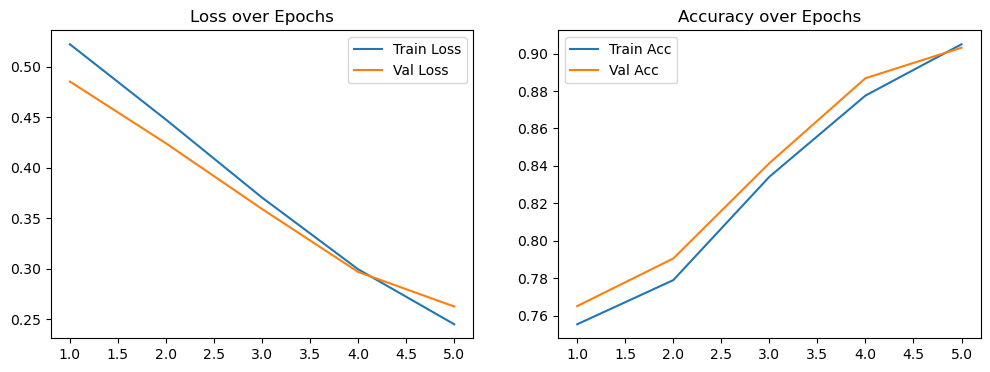

In [30]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images, labels
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training stats
        epoch_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate average training loss/accuracy
    epoch_train_loss /= total_train
    train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    epoch_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images, labels
            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss /= total_val
    val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}: "
          f"Train Loss {epoch_train_loss:.4f}, Train Acc {train_accuracy:.4f}, "
          f"Val Loss {epoch_val_loss:.4f}, Val Acc {val_accuracy:.4f}")
    torch.save(model.state_dict(), f"model/model_epoch_{epoch+1}.pth")

# Plotting
epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()